In [12]:
from matplotlib import pyplot as plt
import os
from scipy.io.wavfile import read
import scipy
from scipy import stats
import numpy as np
import torch
import librosa 
from librosa.feature import melspectrogram
import scaleogram as scg 
from logmmse import logmmse_from_file
import pywt
import pickle
import seaborn as sns
from scipy.stats import kurtosis, skew
import pandas as pd
import sys
from AEspeech import AEspeech
import cv2
# from phonetGM2 import Phonet
from SpecDatset import SpecDataset

In [13]:
from SpecDatset import SpecDataset
import sklearn
import time
import torch
import numpy as np
import pandas as pd
import os
import sys
from CAE import CAEn
PATH=os.getcwd()
sys.path.append(PATH+"/toolbox/")
import traintestsplit as tts

In [14]:
#Visualize training, validation results and reconstruction error for pd vs. hc speakers for all utterance types.
mods=['CAE']
reps=['broadband','narrowband', 'wvlt'] #'spec' => mfccs, 'wvlt' => wavelet coefficients as features
outs=['training','validation']
bns=256

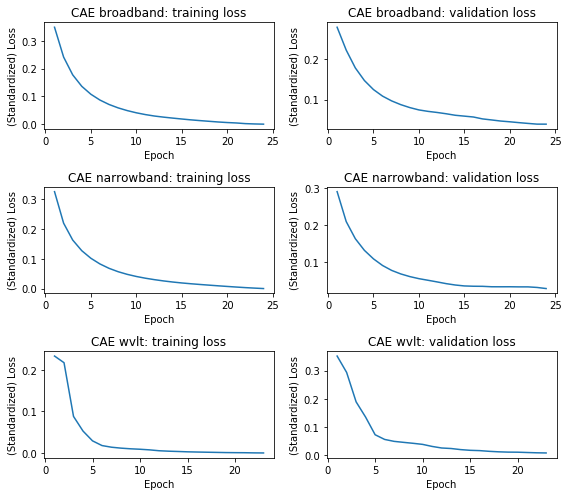

In [15]:
fig,ax=plt.subplots(nrows=len(reps)*len(mods),ncols=len(outs), figsize=(8,7))
current_ax=-1
for nmod,mod in enumerate(mods):
    for nrep,rep in enumerate(reps):
        load_path=PATH+'/pts/'+rep+'/'+'loss_'+str(bns)+'_'+mod+'.csv'
        with open(load_path, 'rb') as handle:
            data = pd.read_csv(handle, header=None)
        current_ax+=1
                    
        for i,out in enumerate(outs):
            ax_curr=ax[current_ax][i]
            data=(data-np.min(np.min(data)))/(np.max(np.max(data))-np.min(np.min(data)))
            ax_curr.plot(data.iloc[1:,i])

            if i==0:
                ax_curr.set_title(mod+" "+rep+": "+out+" loss")
            else:
                ax_curr.set_title(mod+" "+rep+": "+out+" loss")
            ax_curr.set_ylabel("(Standardized) Loss")
            ax_curr.set_xlabel("Epoch")
            plt.tight_layout()

6


C:\Users\Gabriel\Anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


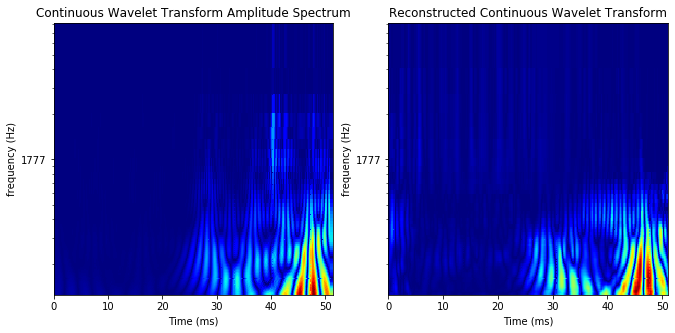

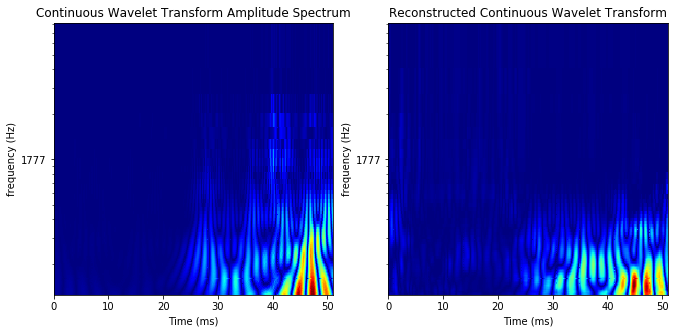

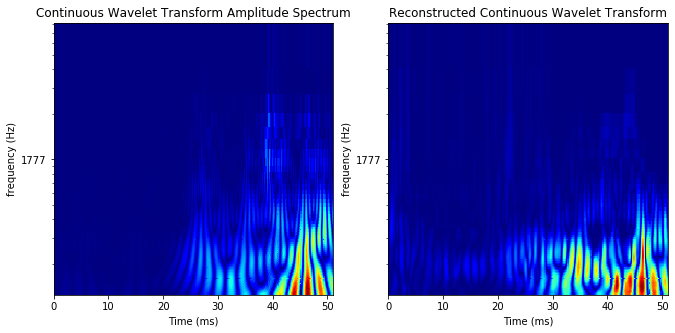

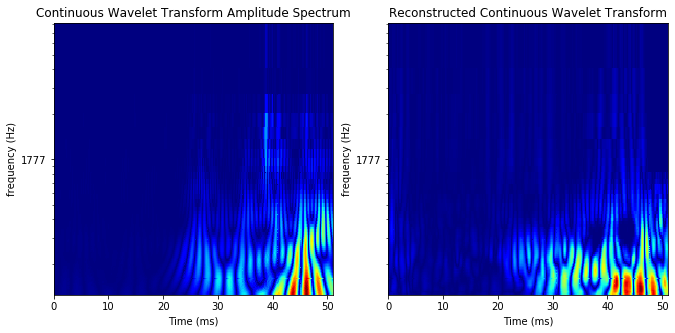

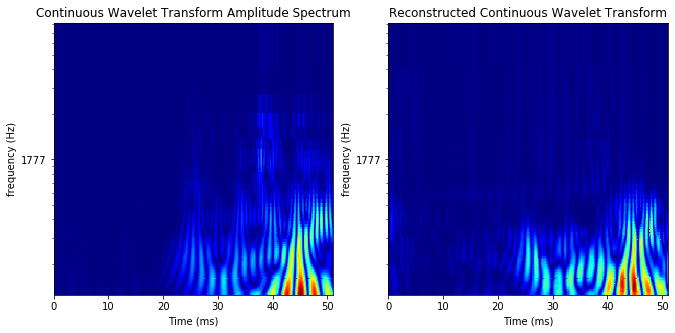

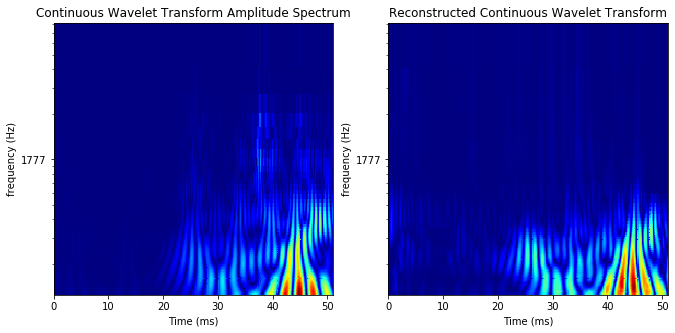

In [16]:
"""
Reconstruct speech representation for individual test speaker speech files based on CAE/RAE models for wvlt and spectral representations.
Test wav files not used for training.
"""
PATH=os.getcwd()
# path_audio=PATH+'/tedx_spanish_corpus/speech/test/'

#SPECIFY path_audio and and file in directory
path_audio=PATH+'/pdSpanish/speech/pataka/pd/'
spk=2
wav_file=path_audio+os.listdir(path_audio)[spk]
TIME_STEPS=256

#SPECIFY model type and representation 
mod='CAE' #'CAE' or 'RAE'
rep='wvlt' #'broadband/narrowband' => mel spectrogram, 'wvlt' => wavelet coefficients as features

fs_in, signal=read(wav_file)
signal=signal-np.mean(signal)
signal=signal/np.max(np.abs(signal))

#set loop parameters
unit=256
num_files=len(os.listdir(path_audio))

# for mod in models:
aespeech=AEspeech(model=mod,units=unit,rep=rep)
if rep=='spec' or rep=='narrowband' or rep=='broadband':
    mat,sig_len=aespeech.compute_spectrograms(wav_file, plosives_only=0,volta=1)
if rep=='wvlt':
    mat,freqs=aespeech.compute_cwt(wav_file)
    
# imag=melspectrogram(signal, sr=fs_in, n_fft=1024, win_length=80, hop_length=48, n_mels=64, fmax=fs_in//2)
# spec_len=imag.shape[1]
# mat=nn.Fold(mat,kernel_size=(128,126), stride=(1,8000/sig_len))

sig_len=len(signal)
if torch.cuda.is_available():
    mat=mat.cuda()
    
# mat=aespeech.standard(mat)
to,bot=aespeech.AE.forward(mat)
# if rep=='wvlt':
# mat=aespeech.destandard(mat)
to=aespeech.destandard(to)



if rep=='spec' or rep=='narrowband' or rep=='broadband':
    aespeech.show_spectrograms(sig_len=sig_len,spectrograms1=mat[0:5,:,:,:],spectrograms2=to[0:5,:,:,:])
if rep=='wvlt':
    aespeech.show_scalograms(np.arange(TIME_STEPS),coefs1=mat[0:10,:,:,:],coefs2=to[0:10,:,:,:], freqs=freqs, hop=2, yaxis='frequency', ylabel='frequency (Hz)')


In [ ]:
mat_error=(mat[:,0,:,:]-to[:,0,:,:])**2
error=torch.mean(mat_error,2).detach().numpy()
error=(error-error.mean())/error.std()
# kurtosis(error,axis=0)
# np.array([np.mean(error,axis=0),np.std(error,axis=0),skew(error,axis=0),kurtosis(error,axis=0)])

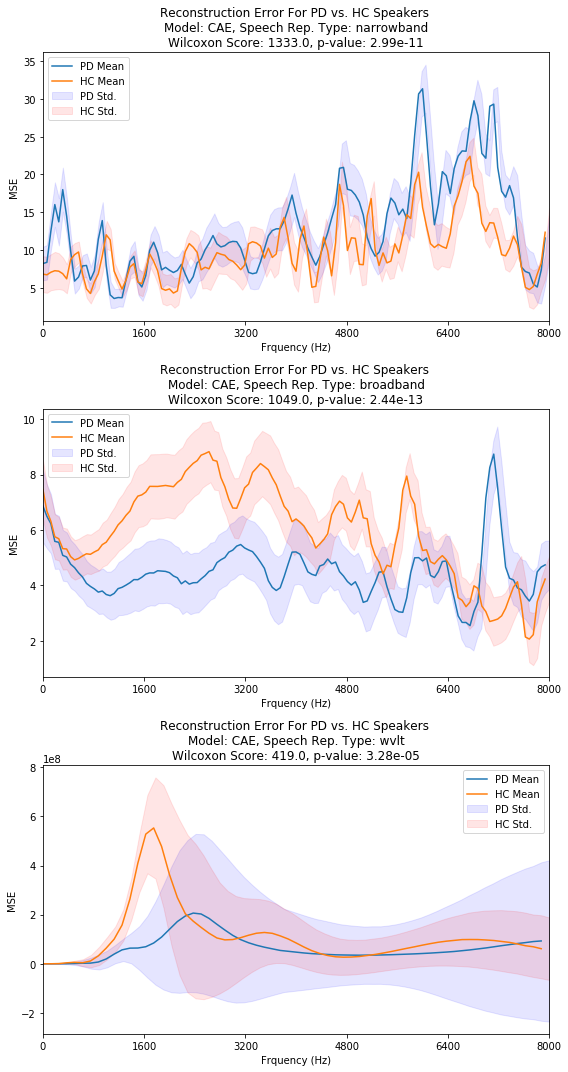

In [17]:
"""
VISUALIZE reconstruction error for pd vs. hc speakers for all utterance types.
"""

fig,ax=plt.subplots(nrows=3,ncols=1, figsize=(8,15))
cs=['b','r']

mods=['CAE']
reps=['narrowband','broadband','wvlt']

for nmod,mod in enumerate(mods):
    for nrep,rep in enumerate(reps):
        load_path=PATH+'/pts/reconErrs/'+mod+'_'+rep+'.pickle'
        with open(load_path, 'rb') as handle:
            data = pickle.load(handle)
     
        ax_curr=ax[nrep]
        for nspk,spk in enumerate(['pd','hc']):
            means=data[spk]['means'][0,:]
            stds=np.mean(data[spk]['stds'],axis=0)
            ttl="Reconstruction Error For PD vs. HC Speakers \nModel: "+mod+", Speech Rep. Type: "+rep+\
            '\nWilcoxon Score: '+str(scipy.stats.wilcoxon(data['pd']['means'][0,:],data['hc']['means'][0,:])[0])+\
            ", p-value: "+str('{:.3g}'.format(scipy.stats.wilcoxon(data['pd']['means'][0,:],data['hc']['means'][0,:])[1],3))

            under_line=means-stds
            over_line=means+stds

            ax_curr.plot(means)
            ax_curr.fill_between(np.linspace(0,len(stds),len(stds)), under_line, over_line, color=cs[nspk], alpha=.1)

            ax_curr.set_title(ttl)
            ax_curr.set_xticks(np.linspace(0,len(means),6))
            ax_curr.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
            ax_curr.set_xlabel('Frquency (Hz)')
            ax_curr.set_ylabel('MSE')
            ax_curr.set_xlim([0,len(means)])
        #     ax.set_ylim([-.5,1])

            ax_curr.legend(['PD Mean','HC Mean','PD Std.','HC Std.'])
            plt.tight_layout()
            
        

In [21]:
mfda_path=PATH+"/pdSpanish/"
gender=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['gender'].values
load_path=PATH+'/pts/reconErrs/'+mod+'_'+rep+'.pickle'
with open(load_path, 'rb') as handle:
    data = pickle.load(handle)

data
    
# pd_mfdas=mfdas[0:50]
# hc_mfdas=mfdas[50:]
# spk_data

{'pd': {'means': array([[3.28089961e+04, 6.05722930e+04, 2.39334766e+05, ...,
          8.62245520e+07, 9.04998960e+07, 9.29928960e+07],
         [4.84354922e+04, 1.07494775e+04, 1.09024508e+05, ...,
          8.12402176e+08, 8.10225984e+08, 7.90928128e+08],
         [7.95195156e+04, 3.59703008e+04, 7.85697875e+05, ...,
          1.15449587e+09, 1.09797005e+09, 1.01087341e+09],
         ...,
         [2.28667090e+04, 2.00894043e+04, 1.56770406e+05, ...,
          2.23382144e+08, 2.55711008e+08, 2.87967392e+08],
         [2.16846934e+04, 2.33841562e+04, 1.32295984e+05, ...,
          4.08710680e+07, 4.46769560e+07, 4.80691000e+07],
         [6.47553125e+04, 3.15867695e+04, 2.88041562e+05, ...,
          7.41398848e+08, 7.40706112e+08, 7.24374464e+08]]),
  'stds': array([[4.00009219e+04, 8.42916562e+04, 3.23414844e+05, ...,
          8.72472640e+07, 9.11310240e+07, 9.33692720e+07],
         [6.38658320e+04, 1.52299023e+04, 1.29960531e+05, ...,
          7.90533632e+08, 7.86375488e+08, 7.

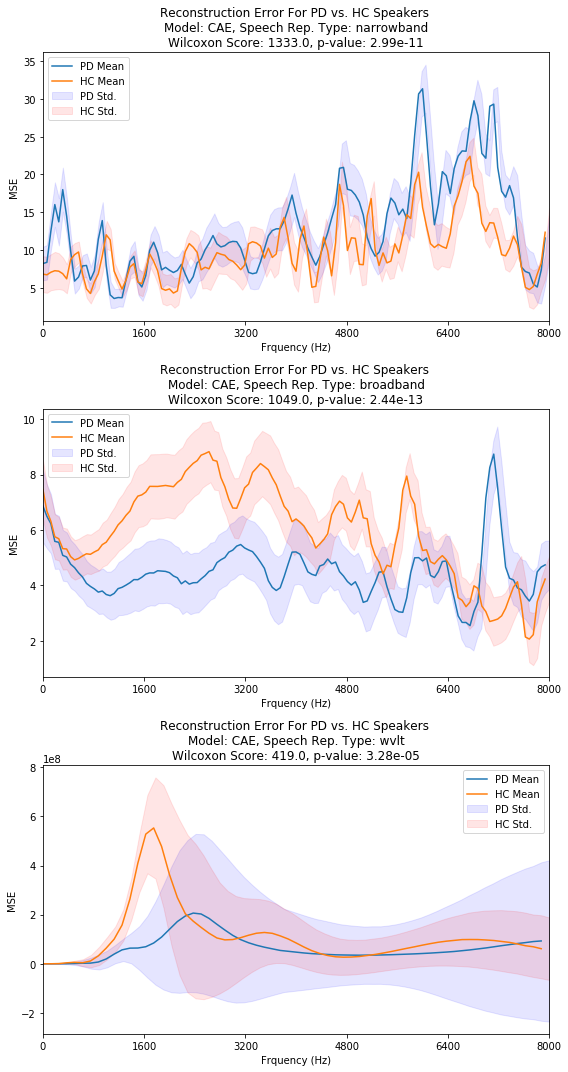

In [17]:
"""
VISUALIZE reconstruction error for pd vs. hc speakers for all utterance types.
"""

fig,ax=plt.subplots(nrows=3,ncols=1, figsize=(8,15))
cs=['b','r']

mods=['CAE']
reps=['narrowband','broadband','wvlt']

for nmod,mod in enumerate(mods):
    for nrep,rep in enumerate(reps):
        load_path=PATH+'/pts/reconErrs/'+mod+'_'+rep+'.pickle'
        with open(load_path, 'rb') as handle:
            data = pickle.load(handle)
     
        ax_curr=ax[nrep]
        for nspk,spk in enumerate(['pd','hc']):
            means=data[spk]['means'][0,:]
            stds=np.mean(data[spk]['stds'],axis=0)
            ttl="Reconstruction Error For PD vs. HC Speakers \nModel: "+mod+", Speech Rep. Type: "+rep+\
            '\nWilcoxon Score: '+str(scipy.stats.wilcoxon(data['pd']['means'][0,:],data['hc']['means'][0,:])[0])+\
            ", p-value: "+str('{:.3g}'.format(scipy.stats.wilcoxon(data['pd']['means'][0,:],data['hc']['means'][0,:])[1],3))

            under_line=means-stds
            over_line=means+stds

            ax_curr.plot(means)
            ax_curr.fill_between(np.linspace(0,len(stds),len(stds)), under_line, over_line, color=cs[nspk], alpha=.1)

            ax_curr.set_title(ttl)
            ax_curr.set_xticks(np.linspace(0,len(means),6))
            ax_curr.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
            ax_curr.set_xlabel('Frquency (Hz)')
            ax_curr.set_ylabel('MSE')
            ax_curr.set_xlim([0,len(means)])
        #     ax.set_ylim([-.5,1])

            ax_curr.legend(['PD Mean','HC Mean','PD Std.','HC Std.'])
            plt.tight_layout()
            
        

In [ ]:
new_to=torch.zeros((to.shape[2],to.shape[2],to.shape[0]*to.shape[3]))
init=0
endi=126
shift=63
for fr in range(to.shape[0]):
    new_to[:,:,init:endi]=to[fr,:,:,:]
    init+=shift
    endi+=shift

In [ ]:
# new_to=to.reshape(1,to.shape[2],to.shape[0]*to.shape[3])
# aespeech.show_spectrograms(sig_len=sig_len,spectrograms1=mat.view(1,mat.shape[1],mat.shape[2],mat.shape[0]*mat.shape[3]))
fig,ax=plt.subplots(ncols=1, figsize=(10,20))
ax.imshow(np.flipud(new_to.detach().numpy()[0,:,:]))

In [ ]:
# #Visualize individual speaker recon error
# means=np.mean(np.mean((mat[:,0,:,:].detach().numpy()-s_to[:,0,:,:].detach().numpy())**2,axis=1),axis=0)
# stds=np.std(np.mean((mat[:,0,:,:].detach().numpy()-s_to[:,0,:,:].detach().numpy())**2,axis=1),axis=0)
# ttl="Reconstruction Error for speaker ID: "+os.listdir(path_audio)[spk]

# under_line=means-stds
# over_line=means+stds

# fig,ax=plt.subplots(1,1)
# plt.plot(means)
# plt.fill_between(np.linspace(0,len(stds),len(stds)), under_line, over_line, color='b', alpha=.1)

# plt.title(ttl)
# ax.set_xticks(np.linspace(0,len(means),6))
# ax.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
# ax.set_xlabel('Frquency (Hz)')
# ax.set_ylabel('MSE')
# ax.set_xlim([0,len(means)])
